# Anharmonic oscillator physics-informed neural network (PINN)

The force is like $-u^3$ and potential energy is like $u^4/4$

## Problem overview

-> Potential energy is: $E_p(u) = \omega_0^2 u^4/4$, and Kinetic energy is: $E_k (u) = (du/dt)^2/2$

-> Total energy is $E = E_p + E_k$

-> The equation to solve is: $d^2u/dt^2 + \omega_0^2 y^3 = 0$


# Used to make 
# Figure 3b in second paper by H. Baty 
## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.


## Environment set up

We train the PINN using PyTorch, using the following environment set up:
```bash

conda create -n pinn python=3
conda activate pinn
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
```



In [13]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from __future__ import division, print_function
import sys

In [14]:
def runge_kutta4(func, r, t, omega, h):
    """ 
    Runge-Kutta 4 method for solving 1st order differential equations
    
    Usage: xNew = rk4(func, r, t, h) 
    
    Given a function  f(x, t, h) = dx/dt and initial starting 
    conditions for x, rk4() returns the next values of x. 
    func:  user defined function for the 1st order differential equations
    r: dependent variable(s)
    t: independent variable(s)
    h: independent variable step value
    """
    k1 = h*func(r, t, omega)
    k2 = h*func(r+0.5*k1, t+0.5*h, omega)
    k3 = h*func(r+0.5*k2, t+0.5*h, omega)
    k4 = h*func(r+k3, t+h, omega)
    return (k1 + 2*k2 + 2*k3 + k4)/6
   
def pendule_Function(r, t, omega):
    """ vectorized function for the pendule """
    x = r[0]
    v = r[1]
    fx = v  
    fv = - omega**2 * x**3  
    return np.array([fx,fv], float)

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## We generate exact solution (classical integration scheme) and training data

> First, we generate some training data from a small part of the true analytical solution.



<function matplotlib.pyplot.show(close=None, block=None)>

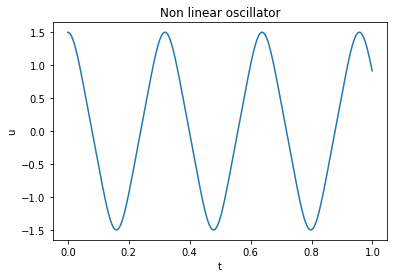

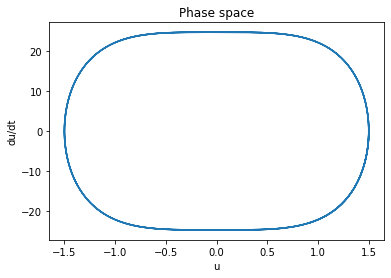

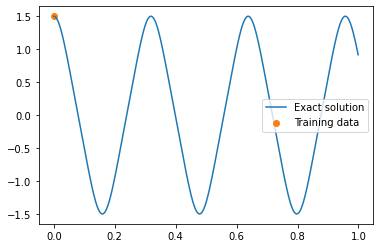

In [15]:
# We define the time step ... important also for visualization ......
nSteps=1000        # Number of time steps for RK4 integration ....
w0=15.5            # Choose the angular velocity value .........

tMin,tMax = 0.0,1.       # Time domain interval ................
tStep = (tMax-tMin)/nSteps
tPoints = np.arange(tMin, tMax, tStep)
xPoints,vPoints = [],[]

# set initial conditions on the state variables
x0,v0 = 1.5,0.0               # Choose the initial conditions x0 and derivative ........
r = np.array([x0,v0], float)

# solve for the time evolution for the true solution obtained with Runge-kutta integration
for t in tPoints:
    xPoints += [r[0]]
    vPoints += [r[1]]
    r += runge_kutta4(pendule_Function, r, t, w0, tStep)

# plot displacement vs time  (true solution)  
fig1 = plt.figure(1)
plt.plot(tPoints, xPoints)
plt.xlabel("t")
plt.ylabel("u")
plt.title("Non linear oscillator")

# plot the phase space (true solution)
fig2 = plt.figure(2)
plt.plot(xPoints, vPoints)
plt.xlabel("u")
plt.ylabel("du/dt")
plt.title("Phase space")

x=torch.Tensor(tPoints).view(-1,1)
y=torch.Tensor(xPoints).view(-1,1)

# We slice out a small number of points from the full domain -> training data extraction ....
x_data = x[0:40:40]
y_data = y[0:40:40]

# We plot data on the true solution and training data ...................................
plt.figure()
plt.plot(tPoints, xPoints, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show

## Normal neural network

> Next, we train a standard neural network (fully connected network) to fit these training points.

>We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

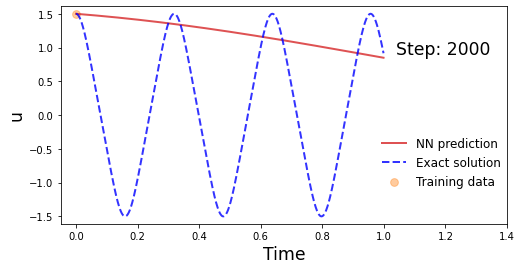

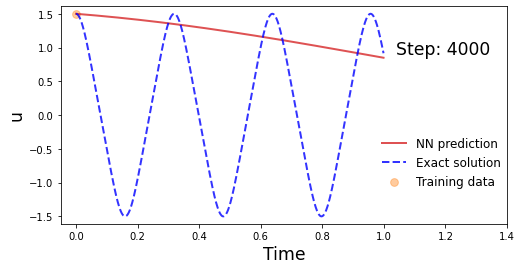

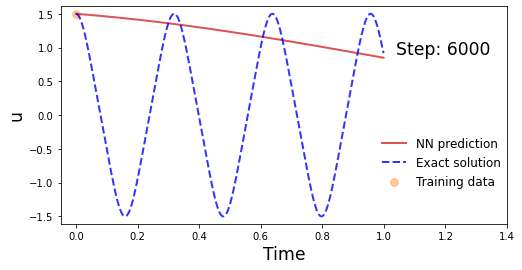

In [16]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,yh, color="tab:red", linewidth=2, alpha=0.8, label="NN prediction")
    plt.plot(x,y, color="blue", linewidth=2, alpha=0.8,linestyle='--', label="Exact solution")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=30, color="tab:green", alpha=0.4, 
                    label='Colloc. points')
    l = plt.legend(loc=(0.71,0.14), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.4)
    plt.ylim(-1.61, 1.61)
    plt.text(1.04,0.9,"Step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.ylabel('u',fontsize="xx-large")
    plt.xlabel('Time',fontsize="xx-large")
    plt.axis("on")
       
# We train standard neural network to fit training data ....................
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=5e-4)
files = []
for i in range(6000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 100 == 0: 
        
        yh = model(x).detach()        
        plot_result(tPoints,xPoints,x_data,y_data,yh)    
        if (i+1) % 2000 == 0: plt.show()
        else: plt.close("all")
            

## PINN

> Finally, we add the underlying differential equation ("physics loss") to the loss function. 

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at 32 points uniformly spaced over the problem domain $([0,1])$. We can calculate the derivatives of the network solution with respect to its input variable at these points using `pytorch`'s autodifferentiation features, and can then easily compute the residual of the differential equation using these quantities.

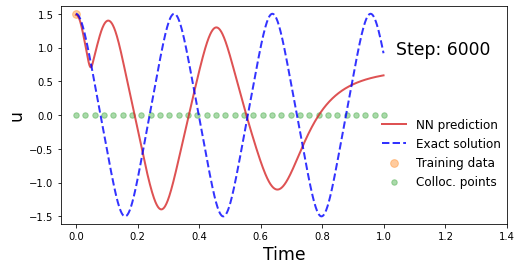

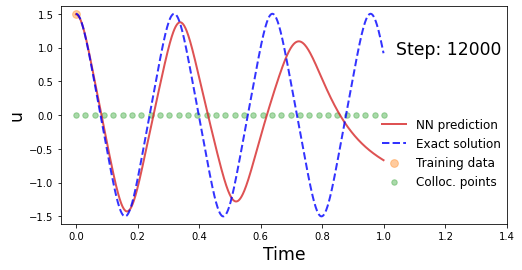

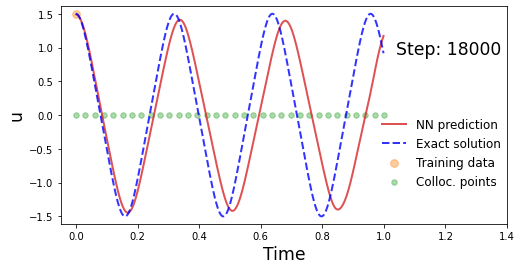

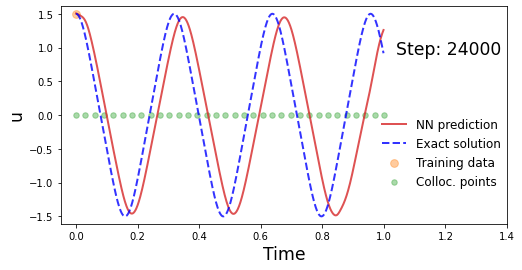

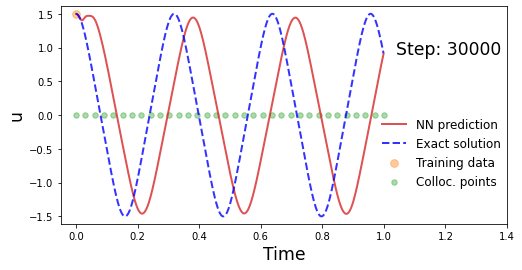

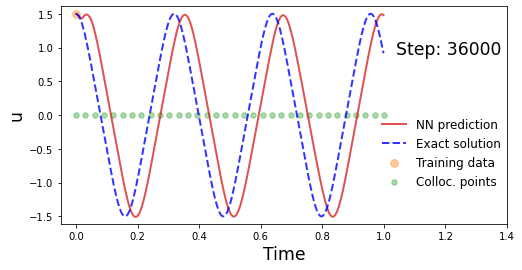

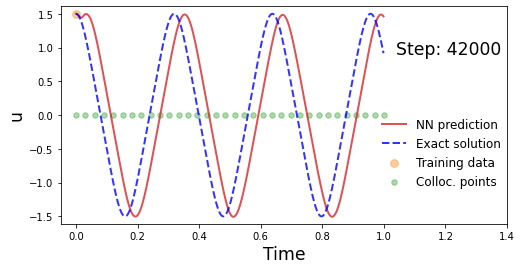

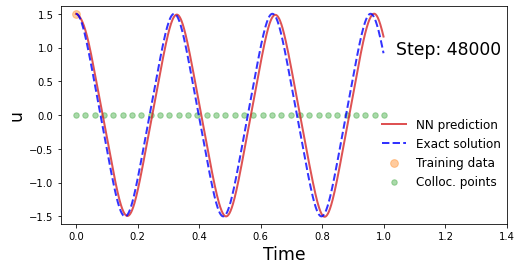

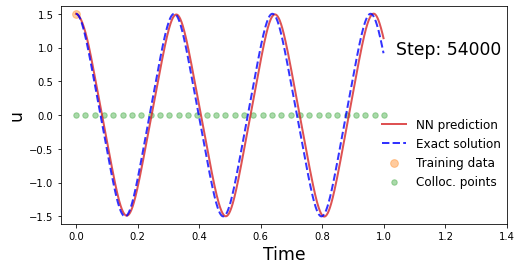

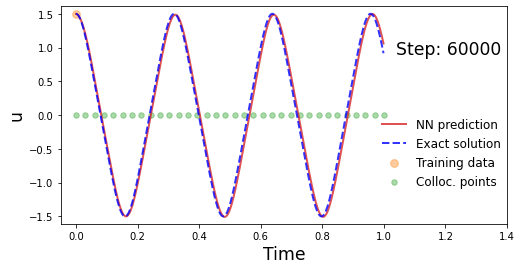

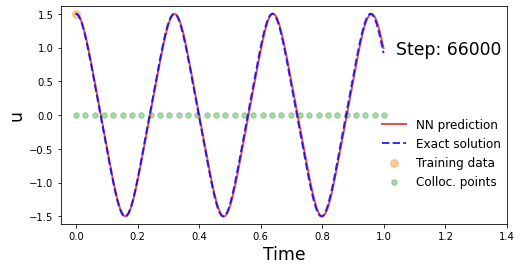

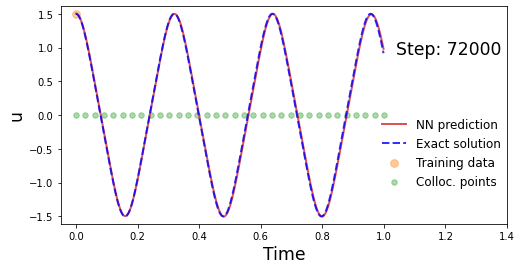

In [17]:
# We define the collocation points ...................................
x_physics = torch.linspace(0,1,34).view(-1,1).requires_grad_(True)# sample locations over the problem domain

torch.manual_seed(777)
model = FCN(1,1,32,5)
optimizer = torch.optim.Adam(model.parameters(),lr=1.e-3)
files = []

loss1_history = []
loss2_history = []
loss3_history = []
loss_history = []
mse_history = []

for i in range(74000):
    optimizer.zero_grad()

    # compute the "data loss" and "physics loss"
    yh = model(x_data)           # predicted solution at training data points .....
    yhp = model(x_physics)       # predicted solution at collocation points ....
    
    # compute derivatives at collocation points .....
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    
    # compute the equation residual ....
    physics= (dx2 + w0**2*yhp**3)
    
    # cpmputes hybrid loss1 (see paper) for 'data' and loss2 for equation ...................
    loss1 = 1*torch.mean((yh-y_data)**2) + 1.e-3*torch.max((dx[0] )**2)
    loss2 = (1e-5)*torch.mean(physics**2) 
    
    # compute the "energy loss" loss3 foy y_0 = 1.5 and zero firts derivative at t=0 .........
    physics2 = (dx**2/2. + w0**2*yhp**4./4. - w0**2*1.5**4./4.)
    loss3 = (1.e-6)*torch.mean(physics2**2)    
    
    # backpropagate total loss .............................
    loss = loss1 + loss2 + loss3 # add two loss terms together
    loss.backward()
    optimizer.step()
       
    # plot the result as training progresses
    if (i+1) % 100 == 0: 
        
        loss1_history.append(loss1.detach())
        loss2_history.append(loss2.detach())
        loss3_history.append(loss3.detach())
        loss_history.append(loss.detach())
        
        yhpp=model(x)
        mse=torch.mean((yhpp-y)**2)
        mse_history.append(mse.detach())
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(tPoints,xPoints,x_data,y_data,yh,xp)
               
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            

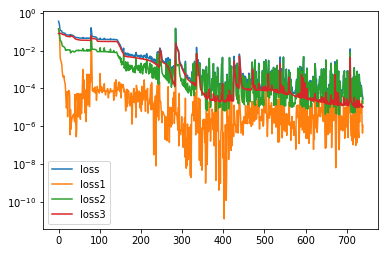

In [18]:
plt.plot(loss_history, label="loss")
plt.plot(loss1_history, label="loss1")
plt.plot(loss2_history, label="loss2")
plt.plot(loss3_history, label="loss3")
plt.yscale('log')
plt.legend()




Text(0.5, 1.0, 'Abolute error')

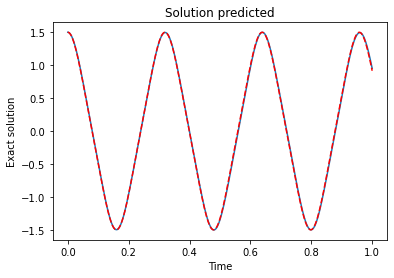

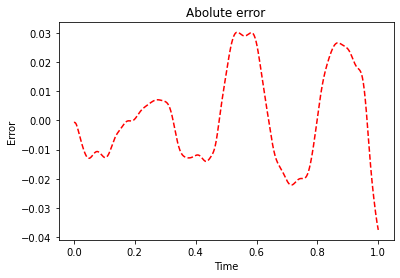

In [19]:
xn = torch.linspace(0,1.,1000).view(-1,1)

ypre = model(xn).detach()

# plot extrapolate    
fig5 = plt.figure(5)
plt.plot(xn, ypre)
plt.plot(xn, y,'r--')
plt.xlabel("Time")
plt.ylabel("Exact solution")
plt.title("Solution predicted")

fig6 = plt.figure(6)
plt.plot(xn, y-ypre,'r--')
plt.xlabel("Time")
plt.ylabel("Error")
plt.title("Abolute error")


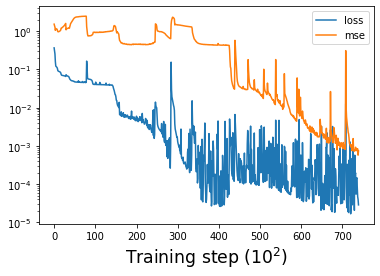

In [20]:
fig33 = plt.figure(33)
plt.plot(loss_history, label="loss")
plt.plot(mse_history, label="mse")
plt.xlabel('Training step ($10^2$)',fontsize="xx-large")
plt.yscale('log')
plt.legend()